In [1]:
import sys, os
sys.path.append(os.getcwd() + '/../cpp/bin')

import PyMorpionSolitaire

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from random import randrange, random, choices
from tqdm import tqdm

In [3]:
from math import exp

In [4]:
def get_random_state():
    game = PyMorpionSolitaire.Game5T('c')
    game.playAtRandom()
    max_score = game.getScore()
    # score = randrange(max_score)
    score = choices(range(max_score), weights=[exp((i - max_score + 1) / 20) for i in range(max_score)])[0]
    game.revertToScore(score)
    return game

In [5]:
def get_random_action():
    game = get_random_state()
    number_of_moves = game.getNumberOfMoves()
    return game, randrange(number_of_moves)

In [6]:
def evaluate(game, move_id):
    game.playByIndex(move_id)
    yes = game.estimateDepth() + 1
    game.undo()
    game.deleteMoveByIndex(move_id)
    no = game.estimateDepth()
    return (yes - no) / (yes + no)

In [7]:
# game, move = get_random_action()
# game.printMove(move)
# neutral = estimate_value(game)
# game.playByIndex(move)
# yes = estimate_value(game) + 1
# game.undo()
# game.deleteMoveByIndex(move)
# no = estimate_value(game)
# neutral, yes, no, (yes - no) / (yes + no)

In [8]:
def sample(reject_single_move = True):
    game, move = get_random_action()
    if reject_single_move and game.getNumberOfMoves() == 1:
        return sample()
    state = game.image()[48:144, 48:144]
    game.playByIndex(move)
    action = game.image()[48:144, 48:144] ^ state
    game.undo()
    label = evaluate(game, move)
    feature = np.concatenate([np.expand_dims(state, axis=0), np.expand_dims(action, axis=0)])
    return feature, label

In [9]:
def batch(size = 200):
    features, labels = list(zip(*[sample() for _ in range(size)]))
    return np.array(features), np.array(labels)

In [10]:
def normalized_sample():
    feature, label = sample()
    if (random() < np.abs(label) + 0.01):
        return feature, label
    return normalized_sample()

In [11]:
def normalized_batch(size = 200):
    features, labels = list(zip(*[normalized_sample() for _ in range(size)]))
    return np.array(features), np.array(labels)

# Analyze one big batch

In [12]:
features, labels = batch(1000)

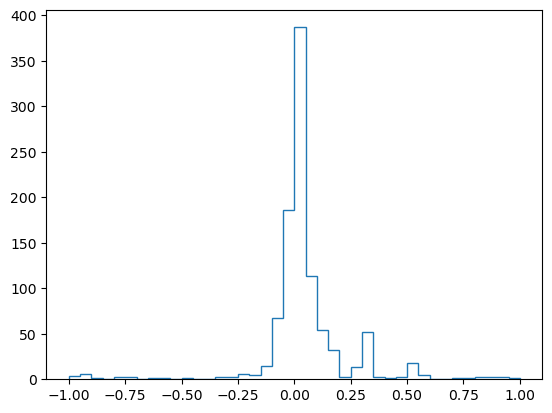

In [13]:
plt.hist(labels, bins=40, range=(-1,1), histtype='step')
plt.show()

In [14]:
normalized_features, normalized_labels = normalized_batch(1000)

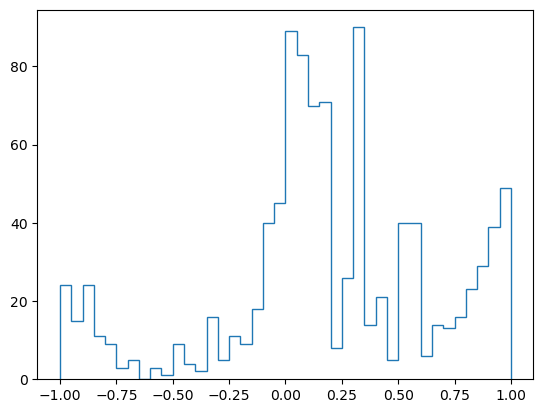

In [15]:
plt.hist(normalized_labels, bins=40, range=(-1,1), histtype='step')
plt.show()

# Store data

In [16]:
for i in tqdm(range(0, 6000)):
    features, labels = batch()
    np.save("data/features_%05d.npy" % i, features)
    np.save("data/labels_%05d.npy" % i, labels)

100%|███████████████████████████████████████| 6000/6000 [35:11<00:00,  2.84it/s]


Compress the data using the following commands in a terminal:

`cd <repo>/deeplearning-diff/data`

`tar -czf labels.tar.gz labels_*.npy`

`tar -czf features.tar.gz features_*.npy`